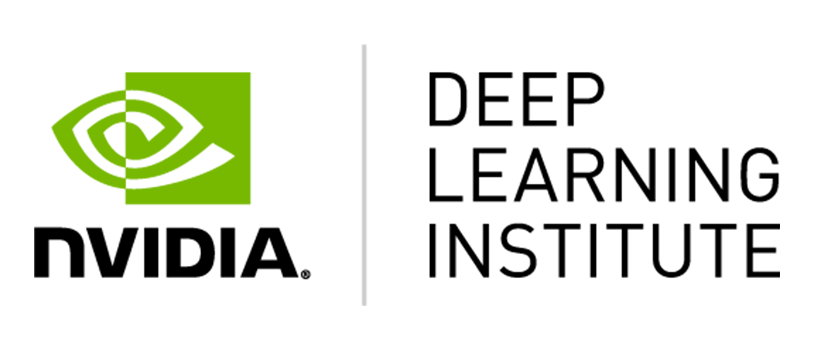<center><img src="../images/DLI Header.png" alt="Header" style="width: 400px;"/></center>

In [2]:
!ls -ltrh /dev/video*

from jetcam.usb_camera import USBCamera
from jetcam.csi_camera import CSICamera
import threading
import time
from utils import preprocess
import torch.nn.functional as F
import torchvision.transforms as transforms
from dataset import ImageClassificationDataset
import ipywidgets
import traitlets
from IPython.display import display
from jetcam.utils import bgr8_to_jpeg
import torch
import torchvision
import os
import IPython

camera = USBCamera(width=224, height=224, capture_device=0) # confirm the capture_device number
camera.running = True

TASK = 'Manga'   

CATEGORIES = ['Volume1', 'Volume2', 'Volume3', 'Volume4', 'Volume5', 'Volume6', 'Volume7', 'Volume8', 'Volume9', 'Volume10', 'Volume11', 'Volume12', 'Volume13']

#DATASETS = ['A', 'B']
DATASETS = ['A', 'B', 'C', 'D']

TRANSFORMS = transforms.Compose([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

datasets = {}
for name in DATASETS:
    datasets[name] = ImageClassificationDataset('../data/classification/' + TASK + '_' + name, CATEGORIES, TRANSFORMS

DATA_DIR = '/nvdli-nano/data/classification/'
!mkdir -p {DATA_DIR}
                                            
dataset = datasets[DATASETS[0]]
camera.unobserve_all()

camera_widget = ipywidgets.Image()
traitlets.dlink((camera, 'value'), (camera_widget, 'value'), transform=bgr8_to_jpeg)
dataset_widget = ipywidgets.Dropdown(options=DATASETS, description='dataset')
category_widget = ipywidgets.Dropdown(options=dataset.categories, description='category')
count_widget = ipywidgets.IntText(description='count')
save_widget = ipywidgets.Button(description='add')
count_widget.value = dataset.get_count(category_widget.value)      
                                                
def set_dataset(change):
    global dataset
    dataset = datasets[change['new']]
    count_widget.value = dataset.get_count(category_widget.value)
dataset_widget.observe(set_dataset, names='value')
                                                
def update_counts(change):
    count_widget.value = dataset.get_count(change['new'])
category_widget.observe(update_counts, names='value')
                                                
def save(c):
    dataset.save_entry(camera.value, category_widget.value)
    count_widget.value = dataset.get_count(category_widget.value)
save_widget.on_click(save)

data_collection_widget = ipywidgets.VBox([
    ipywidgets.HBox([camera_widget]), dataset_widget, category_widget, count_widget, save_widget
])          
                                                
device = torch.device('cuda')
model = torchvision.models.resnet18(pretrained=not False)
model.fc = torch.nn.Linear(512, len(dataset.categories))
model = model.to(device)

model_save_button = ipywidgets.Button(description='save model')
model_load_button = ipywidgets.Button(description='load model')
model_path_widget = ipywidgets.Text(description='model path', value='/nvdli-nano/data/classification/my_model.pth')
                                                
def load_model(c):
    model.load_state_dict(torch.load(model_path_widget.value))
model_load_button.on_click(load_model)
    
def save_model(c):
    torch.save(model.state_dict(), model_path_widget.value)
model_save_button.on_click(save_model)

model_widget = ipywidgets.VBox([
    model_path_widget,
    ipywidgets.HBox([model_load_button, model_save_button])
])


state_widget = ipywidgets.ToggleButtons(options=['stop', 'live'], description='state', value='stop')
prediction_widget = ipywidgets.Text(description='prediction')
score_widgets = []
for category in dataset.categories:
    score_widget = ipywidgets.FloatSlider(min=0.0, max=1.0, description=category, orientation='vertical')
    score_widgets.append(score_widget)

def live(state_widget, model, camera, prediction_widget, score_widget):
    global dataset
    while state_widget.value == 'live':
        image = camera.value
        preprocessed = preprocess(image)
        output = model(preprocessed)
        output = F.softmax(output, dim=1).detach().cpu().numpy().flatten()
        category_index = output.argmax()
        prediction_widget.value = dataset.categories[category_index]
        for i, score in enumerate(list(output)):
            score_widgets[i].value = score
            
def start_live(change):
    if change['new'] == 'live':
        execute_thread = threading.Thread(target=live, args=(state_widget, model, camera, prediction_widget, score_widget))
        execute_thread.start()

state_widget.observe(start_live, names='value')

live_execution_widget = ipywidgets.VBox([
    ipywidgets.HBox(score_widgets),
    prediction_widget,
    state_widget
])

BATCH_SIZE = 8

optimizer = torch.optim.Adam(model.parameters())

                                                
epochs_widget = ipywidgets.IntText(description='epochs', value=1)
eval_button = ipywidgets.Button(description='evaluate')
train_button = ipywidgets.Button(description='train')
loss_widget = ipywidgets.FloatText(description='loss')
accuracy_widget = ipywidgets.FloatText(description='accuracy')
progress_widget = ipywidgets.FloatProgress(min=0.0, max=1.0, description='progress')

def train_eval(is_training):
    global BATCH_SIZE, LEARNING_RATE, MOMENTUM, model, dataset, optimizer, eval_button, train_button, accuracy_widget, loss_widget, progress_widget, state_widget
    
    try:
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True
        )

        state_widget.value = 'stop'
        train_button.disabled = True
        eval_button.disabled = True
        time.sleep(1)

        if is_training:
            model = model.train()
        else:
            model = model.eval()
        while epochs_widget.value > 0:
            i = 0
            sum_loss = 0.0
            error_count = 0.0
            for images, labels in iter(train_loader):
                images = images.to(device)
                labels = labels.to(device)

                if is_training:
                    optimizer.zero_grad()
                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)

                if is_training:
                   loss.backward()
                   optimizer.step()

            
                error_count += len(torch.nonzero(outputs.argmax(1) - labels).flatten())
                count = len(labels.flatten())
                i += count
                sum_loss += float(loss)
                progress_widget.value = i / len(dataset)
                loss_widget.value = sum_loss / i
                accuracy_widget.value = 1.0 - error_count / i
                
            if is_training:
                epochs_widget.value = epochs_widget.value - 1
            else:
                break
    except e:
        pass
    model = model.eval()

    train_button.disabled = False
    eval_button.disabled = False
    state_widget.value = 'live'
    
train_button.on_click(lambda c: train_eval(is_training=True))
eval_button.on_click(lambda c: train_eval(is_training=False))
    
train_eval_widget = ipywidgets.VBox([
    epochs_widget,
    progress_widget,
    loss_widget,
    accuracy_widget,
    ipywidgets.HBox([train_button, eval_button])
])
7= 890-560#
all_widget = ipywidgets.VBox([
    ipywidgets.HBox([data_collection_widget, live_execution_widget]), 
    train_eval_widget,
    model_widget
])

display(all_widget)                                                

camera created


### Display the Interactive Tool!

The interactive tool includes widgets for data collection, training, and testing.

<center><img src="../images/classification_tool_key2.png" alt="tool key" width=500/></center>
<br>
<center><img src="../images/classification_tool_key1.png" alt="tool key"/></center>

Execute the cell below to create and display the full interactive widget.  Follow the instructions in the online DLI course pages to build your project.

In [ ]:
7= 890-560# Combine all the widgets into one display
all_widget = ipywidgets.VBox([
    ipywidgets.HBox([data_collection_widget, live_execution_widget]), 
    train_eval_widget,
    model_widget
])

display(all_widget)

<h1 style="background-color:#76b900;"></h1>

## Before you go...<br><br>Shut down the camera and/or notebook kernel to release the camera resource

In [ ]:
# Attention!  Execute this cell before moving to another notebook
# The USB camera application only requires that the notebook be reset
# The CSI camera application requires that the 'camera' object be specifically released

import os
import IPython

if type(camera) is CSICamera:
    print("Ignore 'Exception in thread' tracebacks\n")
    camera.cap.release()

os._exit(00)

Return to the DLI course pages for the next instructions.

<center><img src="../images/DLI Header.png" alt="Header" style="width: 400px;"/></center>